In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import pyodbc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [4]:
def get_netsuite(query):
    '''
    Query NetSuite using ODBC
    Planning to switch to JDBC or REST API
    '''
    cnxn = pyodbc.connect('DSN=NetSuiteML;uid=minh.le@vuanem.com;PWD=BI@2023cute')
    sales_order = pd.read_sql(query, cnxn)
    print(sales_order.head())
    return sales_order

In [5]:
netsuite_query = '''
    SELECT
        CAST(TRANSACTIONS.TRANDATE AS date) AS TRANDATE,
        - SUM(TRANSACTION_LINES.NET_AMOUNT) AS 'NET_AMOUNT'
    FROM
        "Vua Nem Joint Stock Company"."Vua Nem - Storehouse Officer".TRANSACTION_LINES TRANSACTION_LINES
        LEFT JOIN "Vua Nem Joint Stock Company"."Vua Nem - Storehouse Officer".TRANSACTIONS TRANSACTIONS ON TRANSACTION_LINES.TRANSACTION_ID = TRANSACTIONS.TRANSACTION_ID
        LEFT JOIN "Vua Nem Joint Stock Company"."Vua Nem - Storehouse Officer".INVENTORY_ITEMS ON TRANSACTION_LINES.ITEM_ID = INVENTORY_ITEMS.ITEM_ID
        LEFT JOIN "Vua Nem Joint Stock Company"."Vua Nem - Storehouse Officer".SERVICE_ITEMS ON SERVICE_ITEMS.ITEM_ID = TRANSACTION_LINES.ITEM_ID
    WHERE
        TRANSACTION_LINES.ACCOUNT_ID IN (480, 482, 487, 498, 505, 508, 509, 510, 511, 54, 1079, 1170)
        AND TRANSACTIONS.TRANSACTION_TYPE IN ('Sales Order')
        AND TRANSACTIONS.STATUS <> 'Closed'
        AND (
                (INVENTORY_ITEMS.DISPLAYNAME IS NOT NULL)
                OR(SERVICE_ITEMS.ITEM_ID IN ('136263', '136264'))
        )
    GROUP BY
        TRANSACTIONS.TRANDATE
    ORDER BY TRANSACTIONS.TRANDATE
        '''

In [6]:
df = get_netsuite(netsuite_query)

TRANDATE    NET_AMOUNT
0  2018-06-26  5.077728e+06
1  2018-06-30  2.621633e+09
2  2018-07-01  3.523492e+08
3  2018-07-02  3.614652e+08
4  2018-07-03  3.742462e+08


In [7]:
df2 = df.copy()

In [18]:
train_set = df2[['NET_AMOUNT']].iloc[:-40,:]
test_set = df2[['NET_AMOUNT']].iloc[-40:,:]

In [19]:
day_to_window = 30

In [20]:
sc = MinMaxScaler(feature_range=(0,1))
stage_train = sc.fit_transform(train_set.values.reshape(-1,1))
X_train = []
y_train = []
for i in range(day_to_window, len(stage_train)):
    X_train.append(stage_train[i-day_to_window:i, :])
    y_train.append(stage_train[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [21]:
dataset_total = pd.concat((train_set, test_set), axis = 0)
inputs = dataset_total[len(df) - len(test_set) - day_to_window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(day_to_window, day_to_window + len(test_set)):
    X_test.append(inputs[i-day_to_window:i, :])
    y_test.append(inputs[i, :])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [22]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='loss')
nn = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, batch_size = 32)

 - loss: 0.0078 - mean_absolute_error: 0.0656 - val_loss: 0.0066 - val_mean_absolute_error: 0.0647
Epoch 81/200
23/23 [==============================] - 1s 30ms/step - loss: 0.0080 - mean_absolute_error: 0.0664 - val_loss: 0.0067 - val_mean_absolute_error: 0.0669
Epoch 82/200
23/23 [==============================] - 1s 30ms/step - loss: 0.0073 - mean_absolute_error: 0.0630 - val_loss: 0.0066 - val_mean_absolute_error: 0.0657
Epoch 83/200
23/23 [==============================] - 1s 30ms/step - loss: 0.0072 - mean_absolute_error: 0.0630 - val_loss: 0.0069 - val_mean_absolute_error: 0.0686
Epoch 84/200
23/23 [==============================] - 1s 30ms/step - loss: 0.0074 - mean_absolute_error: 0.0647 - val_loss: 0.0065 - val_mean_absolute_error: 0.0646
Epoch 85/200
23/23 [==============================] - 1s 30ms/step - loss: 0.0079 - mean_absolute_error: 0.0648 - val_loss: 0.0064 - val_mean_absolute_error: 0.0639
Epoch 86/200
23/23 [==============================] - 1s 31ms/step - loss: 0

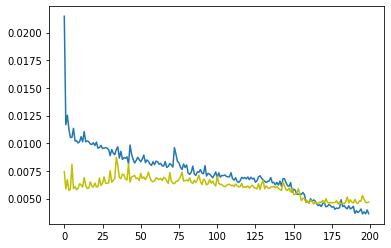

In [27]:
fig, ax = plt.subplots()
ax.plot(nn.history['loss'])
ax.plot(nn.history['val_loss'], color='y')

In [24]:
pred = model.predict(X_test)
pred = sc.inverse_transform(pred)
real = test_set.values

In [25]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='real',
        x=df2.iloc[-40:,:]['TRANDATE'],
        y=real.flatten()
    )
)

fig.add_trace(
    go.Scatter(
        name='pred',
        x=df2.iloc[-40:,:]['TRANDATE'],
        y=pred.flatten()
    )
)
fig.show()

In [26]:
mean_absolute_error(real[:-2], pred[:-2])

137520144.3846154